<a href="https://colab.research.google.com/github/Anjan-AI/TSAI-EVA5/blob/master/Session%2010%20-%20Advanced%20Concepts%20in%20Training%20%26%20Learning%20Rates/EVA5_Session_10_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Added the modular files to the drive and added to path

In [21]:
%rm -rf TSAI-EVA5/

In [22]:

!git clone https://github.com/Anjan-AI/TSAI-EVA5.git

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 594 (delta 166), reused 261 (delta 69), pack-reused 195
Receiving objects: 100% (594/594), 32.16 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (239/239), done.


In [23]:
import sys
sys.path.append('/content/TSAI-EVA5/Session 10 - Advanced Concepts in Training & Learning Rates/')
#sys.path.append('/content/TSAI-EVA5/Session 9 - DATA AUGMENTATION')

### Import all the Library

In [24]:
import torch
import os
import torchvision
import torchvision.transforms as transfroms
from Dataset.dataset import Dataset,cifar10_classes
from Dataset.image_augmentations import AlbumentationTransforms
from Utils.SetCuda import set_seed,initialize_cuda
from Utils.utilities import print_model_summary,cross_entropy_loss
from Utils.evaluate import show_misclassified_images,evaluate_classwise_accuracy
from Utils.GradCam import GradCamView
from Utils.show_image import imshow ,show_train_data
from models.resnet import ResNet18
from Training.Training_Testing import train ,test,runmodel

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from Utils.lr_finder import LRFinder

In [25]:
classes = cifar10_classes()
#define the transformation 
train_transform = AlbumentationTransforms(augmentation = True, mean=(0.4914, 0.4822, 0.4465) ,std_dev =(0.2471, 0.2435, 0.2616),horizontal_flip_prob=0.6,vertical_flip_prob=0.6,rotate_degree =30.0,cutout= True)
test_transform = AlbumentationTransforms(augmentation = True, mean=(0.4914, 0.4822, 0.4465) ,std_dev =(0.2471, 0.2435, 0.2616))
# allocate the transfroamtions to the the Data class
Data = Dataset(train_transform, test_transform)
# downlaod the data
train_set = Data.download_cifar10dataset(train = True)
test_set = Data.download_cifar10dataset(train = False)

#check for the GUP avaliblbity and manual seeding
seed =1
cuda,device = initialize_cuda(seed)

Files already downloaded and verified
Files already downloaded and verified
GPU Available? True


In [26]:
# Load the test and train data , set the batch size & Num_workeres.
train_loader = Data.data_loader(train_set,cuda= cuda ,batch_size = 64 , num_workers = 4 )
test_loader = Data.data_loader(test_set,cuda= cuda ,batch_size = 64 , num_workers = 4 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

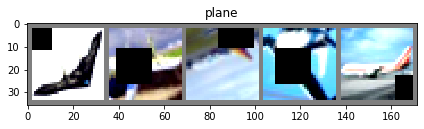

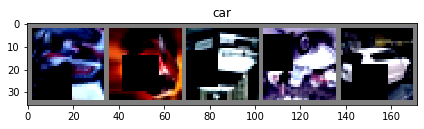

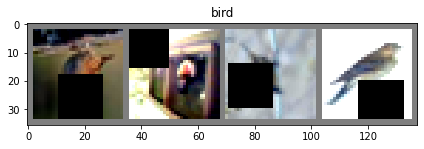

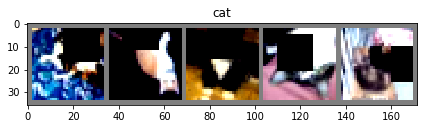

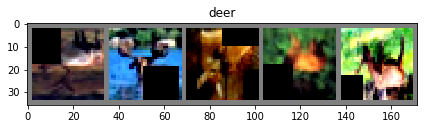

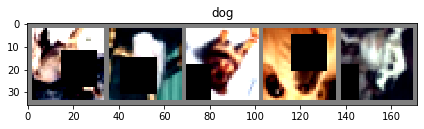

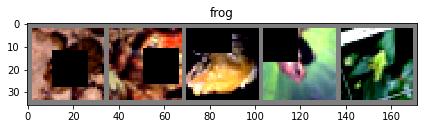

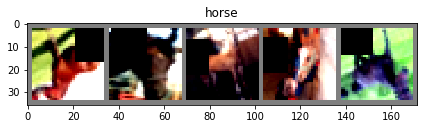

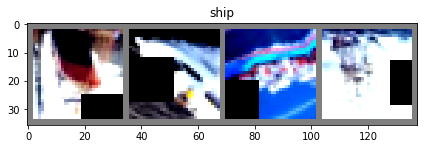

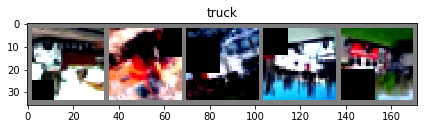

In [27]:
show_train_data(train_loader, classes)

In [28]:
# laod the model and print teh summary
model = ResNet18()
print_model_summary(model, input_size = (3,32,32),device =device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## Best Learning Rate Finder 

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.45E-02


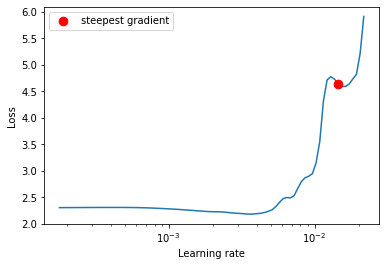

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd1fcd1d1d0>,
 0.014481182276745335)

In [29]:
criterion = cross_entropy_loss() 
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9,weight_decay = 0.0001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=10, num_iter=200 ,step_mode="exp")
lr_finder.plot()

In [30]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
Best_lr

0.003612342699709432

In [31]:
lr_finder.reset()

## ReduceLROnPlateau implentation

In [32]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS = 50 # set the no of epcohs

criterion = cross_entropy_loss()  # Create loss function
optimizer = optim.SGD(model.parameters(), lr=Best_lr, momentum=0.9) #define optimzer
#scheduler = StepLR(optimizer, step_size=40, gamma=0.1) # define scheduler
scheduler = ReduceLROnPlateau(optimizer, patience = 5 ,min_lr=1e-4)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
print(device)
model = model.to(device)
runmodel(model,device,train_loader,test_loader,optimizer,scheduler,EPOCHS,criterion, train_losses,train_acc,test_losses,test_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

cuda
EPOCH: 0


Loss=1.316801905632019 Batch_id=781 Accuracy=38.90: 100%|██████████| 782/782 [01:04<00:00, 12.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 4869/10000 (48.69%)

EPOCH: 1


Loss=1.5981703996658325 Batch_id=781 Accuracy=52.09: 100%|██████████| 782/782 [01:04<00:00, 12.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 5905/10000 (59.05%)

EPOCH: 2


Loss=1.2789280414581299 Batch_id=781 Accuracy=58.34: 100%|██████████| 782/782 [01:05<00:00, 11.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 6174/10000 (61.74%)

EPOCH: 3


Loss=1.0398147106170654 Batch_id=781 Accuracy=62.82: 100%|██████████| 782/782 [01:05<00:00, 11.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 6796/10000 (67.96%)

EPOCH: 4


Loss=1.0590705871582031 Batch_id=781 Accuracy=65.66: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 6992/10000 (69.92%)

EPOCH: 5


Loss=1.1511807441711426 Batch_id=781 Accuracy=68.22: 100%|██████████| 782/782 [01:06<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 7170/10000 (71.70%)

EPOCH: 6


Loss=1.3527650833129883 Batch_id=781 Accuracy=69.68: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 7329/10000 (73.29%)

EPOCH: 7


Loss=1.1770641803741455 Batch_id=781 Accuracy=71.72: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 7199/10000 (71.99%)

EPOCH: 8


Loss=1.140573263168335 Batch_id=781 Accuracy=73.10: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 7595/10000 (75.95%)

EPOCH: 9


Loss=0.563191294670105 Batch_id=781 Accuracy=74.23: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 7710/10000 (77.10%)

EPOCH: 10


Loss=0.4483109712600708 Batch_id=781 Accuracy=75.27: 100%|██████████| 782/782 [01:05<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 7714/10000 (77.14%)

EPOCH: 11


Loss=0.7783696055412292 Batch_id=781 Accuracy=76.15: 100%|██████████| 782/782 [01:06<00:00, 11.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7812/10000 (78.12%)

EPOCH: 12


Loss=0.35155072808265686 Batch_id=781 Accuracy=77.08: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 7766/10000 (77.66%)

EPOCH: 13


Loss=0.40156877040863037 Batch_id=781 Accuracy=77.57: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8124/10000 (81.24%)

EPOCH: 14


Loss=0.41899484395980835 Batch_id=781 Accuracy=78.59: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 8137/10000 (81.37%)

EPOCH: 15


Loss=0.6373317837715149 Batch_id=781 Accuracy=79.22: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 8032/10000 (80.32%)

EPOCH: 16


Loss=0.438737690448761 Batch_id=781 Accuracy=79.89: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 8035/10000 (80.35%)

EPOCH: 17


Loss=0.4494372010231018 Batch_id=781 Accuracy=80.28: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 7974/10000 (79.74%)

EPOCH: 18


Loss=0.6307168006896973 Batch_id=781 Accuracy=80.78: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8161/10000 (81.61%)

EPOCH: 19


Loss=0.6184291243553162 Batch_id=781 Accuracy=81.41: 100%|██████████| 782/782 [01:06<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8286/10000 (82.86%)

EPOCH: 20


Loss=0.4710942506790161 Batch_id=781 Accuracy=81.76: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8364/10000 (83.64%)

EPOCH: 21


Loss=0.5187968015670776 Batch_id=781 Accuracy=82.05: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8353/10000 (83.53%)

EPOCH: 22


Loss=0.7295950651168823 Batch_id=781 Accuracy=82.33: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8430/10000 (84.30%)

EPOCH: 23


Loss=0.4762243926525116 Batch_id=781 Accuracy=82.84: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8412/10000 (84.12%)

EPOCH: 24


Loss=0.09237108379602432 Batch_id=781 Accuracy=83.41: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 8338/10000 (83.38%)

EPOCH: 25


Loss=0.3009170889854431 Batch_id=781 Accuracy=83.87: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 8551/10000 (85.51%)

EPOCH: 26


Loss=0.16239577531814575 Batch_id=781 Accuracy=84.06: 100%|██████████| 782/782 [01:06<00:00, 11.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 8547/10000 (85.47%)

EPOCH: 27


Loss=0.26103881001472473 Batch_id=781 Accuracy=84.50: 100%|██████████| 782/782 [01:06<00:00, 11.76it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 8444/10000 (84.44%)

EPOCH: 28


Loss=0.9619864821434021 Batch_id=781 Accuracy=84.74: 100%|██████████| 782/782 [01:06<00:00, 11.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8453/10000 (84.53%)

EPOCH: 29


Loss=0.1525096595287323 Batch_id=781 Accuracy=84.93: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8595/10000 (85.95%)

EPOCH: 30


Loss=0.6374353170394897 Batch_id=781 Accuracy=85.39: 100%|██████████| 782/782 [01:06<00:00, 11.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8552/10000 (85.52%)

EPOCH: 31


Loss=0.5326768159866333 Batch_id=781 Accuracy=85.48: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 8586/10000 (85.86%)

EPOCH: 32


Loss=0.3055145740509033 Batch_id=781 Accuracy=85.73: 100%|██████████| 782/782 [01:06<00:00, 11.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8539/10000 (85.39%)

EPOCH: 33


Loss=0.37990230321884155 Batch_id=781 Accuracy=86.04: 100%|██████████| 782/782 [01:05<00:00, 11.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8548/10000 (85.48%)

EPOCH: 34


Loss=0.8149431943893433 Batch_id=781 Accuracy=86.22: 100%|██████████| 782/782 [01:06<00:00, 11.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8539/10000 (85.39%)

EPOCH: 35


Loss=0.7061731815338135 Batch_id=781 Accuracy=86.89: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 8551/10000 (85.51%)

EPOCH: 36


Loss=0.306454598903656 Batch_id=781 Accuracy=89.37: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8817/10000 (88.17%)

EPOCH: 37


Loss=0.46118322014808655 Batch_id=781 Accuracy=89.89: 100%|██████████| 782/782 [01:06<00:00, 11.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8871/10000 (88.71%)

EPOCH: 38


Loss=0.34946903586387634 Batch_id=781 Accuracy=90.18: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8890/10000 (88.90%)

EPOCH: 39


Loss=0.19909906387329102 Batch_id=781 Accuracy=90.42: 100%|██████████| 782/782 [01:05<00:00, 11.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8880/10000 (88.80%)

EPOCH: 40


Loss=0.35369986295700073 Batch_id=781 Accuracy=90.56: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8875/10000 (88.75%)

EPOCH: 41


Loss=0.6129561066627502 Batch_id=781 Accuracy=90.74: 100%|██████████| 782/782 [01:06<00:00, 11.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8914/10000 (89.14%)

EPOCH: 42


Loss=0.4245433807373047 Batch_id=781 Accuracy=90.62: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8895/10000 (88.95%)

EPOCH: 43


Loss=0.1316661834716797 Batch_id=781 Accuracy=90.87: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8911/10000 (89.11%)

EPOCH: 44


Loss=0.2260207235813141 Batch_id=781 Accuracy=91.08: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8924/10000 (89.24%)

EPOCH: 45


Loss=0.14089138805866241 Batch_id=781 Accuracy=91.06: 100%|██████████| 782/782 [01:06<00:00, 11.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8937/10000 (89.37%)

EPOCH: 46


Loss=0.15667615830898285 Batch_id=781 Accuracy=91.40: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8928/10000 (89.28%)

EPOCH: 47


Loss=0.372724711894989 Batch_id=781 Accuracy=91.49: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8938/10000 (89.38%)

EPOCH: 48


Loss=0.35611492395401 Batch_id=781 Accuracy=91.46: 100%|██████████| 782/782 [01:06<00:00, 11.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8942/10000 (89.42%)

EPOCH: 49


Loss=0.3899451196193695 Batch_id=781 Accuracy=91.61: 100%|██████████| 782/782 [01:06<00:00, 11.81it/s]



Test set: Average loss: 0.0051, Accuracy: 8934/10000 (89.34%)



In [33]:
evaluate_classwise_accuracy(model, device, classes, test_loader)

Accuracy of plane : 90 %
Accuracy of   car : 97 %
Accuracy of  bird : 87 %
Accuracy of   cat : 75 %
Accuracy of  deer : 86 %
Accuracy of   dog : 83 %
Accuracy of  frog : 92 %
Accuracy of horse : 91 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %


## Gradcam view of missclassfied Images 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

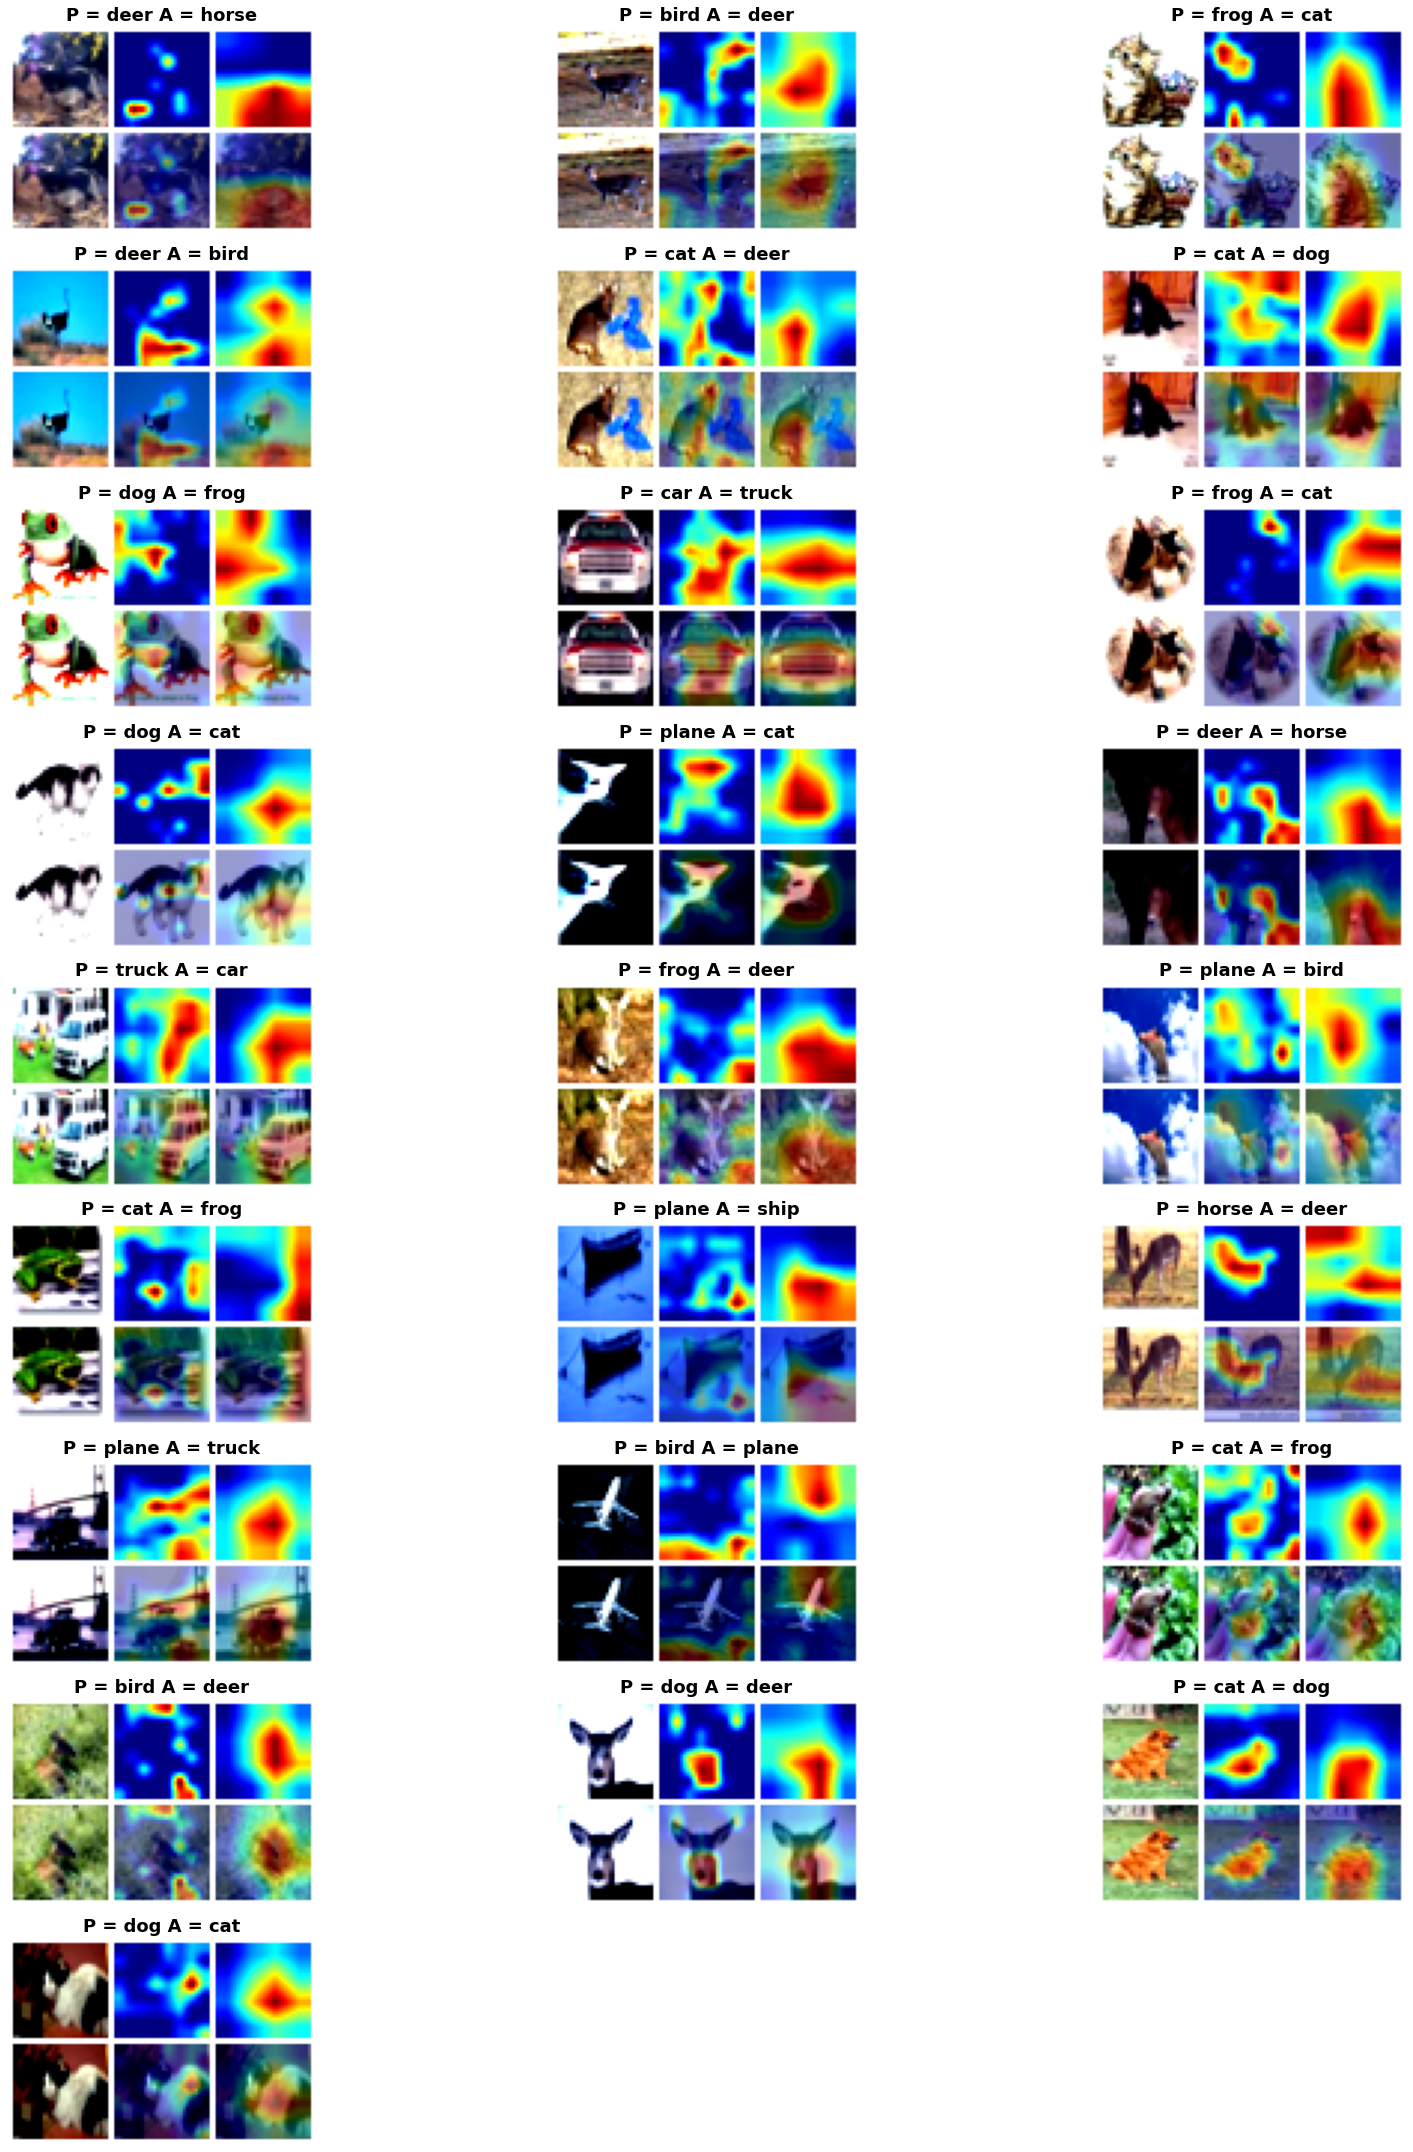

In [34]:
miscalssified_images = show_misclassified_images(model,device,test_loader,classes) # get he misclassfied Images
layers = [model.layer3,model.layer4]  # layers that we want to see in Gradcam.
GradCamView(miscalssified_images,model,classes,layers) # call Gradcam class.

In [47]:
count =0
sum =0
train_batch_acc = []
for i in range(len(train_acc)):
  sum = sum +train_acc[i]
  count = count+1
  if(count == 782):
    train_batch_acc.append(sum/782)
    count =0
    sum =0


In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_metric1(train_acc, test_acc,metric):
    # Initialize a figure
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(11, 9))
    
    # Plot values
    train_acc_plt, = plt.plot(train_acc)
    test_acc_plt, = plt.plot(test_acc)
    

    # Set plot title
    plt.title(f'{metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if ((metric == 'Test loss') or (metric == 'Train loss')) else 'lower'
    plt.legend(
        (train_acc_plt, test_acc_plt),
        ('Train Accuracy', 'Test Accuracy'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 10}
    )



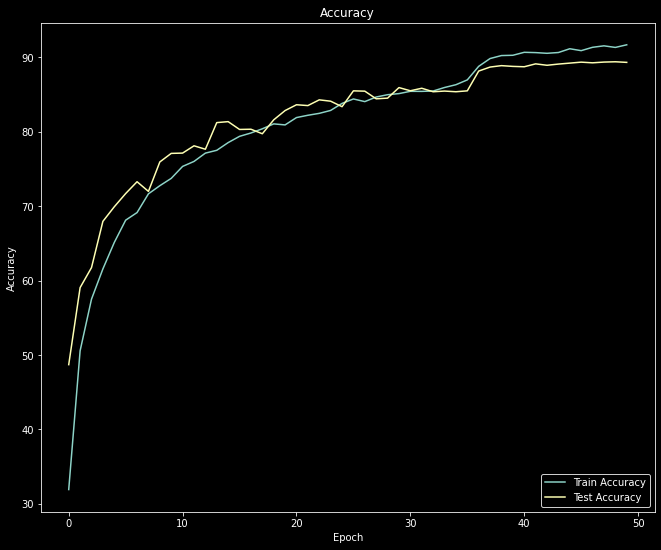

In [52]:
plot_metric1(train_batch_acc, test_acc,metric ='Accuracy')